In [1]:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
import os
import argparse
import tensorflow as tf
import numpy as np

from modules.data_loader import get_processed_datasets
from modules.model_trainer import train_model, evaluate
from modules.training_helper import inspect_model
from modules.experiment_helper import parse_experiment_settings, print_sub_exp_settings

2024-08-28 03:02:26.826789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
experiment_path = 'experiments/Crane.yaml'
experiment_list = parse_experiment_settings(experiment_path)
sub_exp_settings = experiment_list[0]
print_sub_exp_settings(sub_exp_settings)

data:
	dataset_name: mnist:3.*.*
	batch_size: 10000
	shuffle_buffer: 10000
	prefetch_buffer: 3
training_settings:
	max_epoch: 200
	min_epoch: 0
	sleep_freq: 40
	evaluate_freq: 2
	STDP_freq: 0.25
model:
	cortex_spec:
		PCA_cortex_settings:
			PCA_settings:
				leave_out_num: 2
				method: PNMF
				normalizing: by_shape_ratio
				remained_variance: 1
				transpose: False
			new_cortex_split_ratio: 0.5
			refund_with_amplifier: True
			regularize_afterward: False
			split_only_tail: False
			weight_refund: True
			amplifier_base: 10
		STDP_cortex_settings:
			amplifier_settings:
				amplifier_adjust_base: 0.0005
				lower_bound: 0
				optimal_input_thresholds: 1
				upper_bound: 100000000000000
			init_D_P_rate_ratio: 1.0
			init_P_rate: 1e-06
			learning_rate_settings:
				learning_rate_decrease_base: 0
				optimal_output_thresholds: 1
				p_rate_adjust_base: 0
		base_cortex_settings:
			input_latency: 1
			lateral_inhibition_factor: 0.0001
			minimal_weight: 5e-05
			no_skip_links: Fals

In [15]:
old_kernel = np.array(model.cortex.kernel)
old_kernel

array([[1.9966955e-03, 3.5654884e-04, 1.8717401e-03, ..., 1.1143760e-03,
        2.0393832e-03, 2.5770203e-03],
       [1.2253427e-03, 4.6625541e-04, 9.9112117e-04, ..., 1.7580629e-03,
        1.7272490e-03, 1.5607901e-03],
       [2.1600742e-03, 6.3554914e-04, 1.7837390e-04, ..., 1.5072161e-03,
        1.5085200e-03, 6.8660849e-04],
       ...,
       [7.2039322e-05, 1.5190542e-03, 1.6751178e-03, ..., 5.0035911e-04,
        8.4104278e-04, 2.3916550e-03],
       [1.0594648e-03, 1.3947721e-03, 4.3177523e-04, ..., 2.3003359e-04,
        3.0602622e-03, 2.9631592e-03],
       [1.5339146e-03, 1.2366975e-03, 1.6539260e-03, ..., 1.4191355e-03,
        1.6610165e-03, 1.3426386e-03]], dtype=float32)

In [10]:
new_cortex_in_links, right_matrix, amplifier = model.cortex.PCA(old_kernel, **model.cortex.PCA_settings)

/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: 

In [11]:
new_cortex_in_links.shape

(784, 900)

In [12]:
right_matrix.shape

(900, 10)

In [13]:
amplifier

0.5884889224656807

In [23]:
restored_kernel = np.einsum('ab,bc->ac', new_cortex_in_links, right_matrix)*amplifier

In [27]:
old_kernel.min()

0.0

In [28]:
restored_kernel.min()

6.877108e-07

In [26]:
model.cortex.PCA_settings

{'leave_out_num': 2,
 'method': 'PNMF',
 'normalizing': 'by_shape_ratio',
 'remained_variance': 1,
 'transpose': False}

In [4]:
from modules.model_IO import prepare_model_save_path, construct_model

datasets = get_processed_datasets(**sub_exp_settings['data'])

experiment_name = 'handcraft'
sub_exp_name = 'tuning'
model_save_path = prepare_model_save_path(experiment_name, sub_exp_name)
log_path = f'../logs/{experiment_name}/{sub_exp_name}'
summary_writer = tf.summary.create_file_writer(log_path)

2024-08-28 03:02:39.600883: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-28 03:02:39.600931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 99e281f619bd
2024-08-28 03:02:39.600943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 99e281f619bd
2024-08-28 03:02:39.601154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-08-28 03:02:39.601199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1


In [5]:
model = construct_model(sub_exp_settings['model'])

In [6]:
score = evaluate(model, datasets, summary_writer, epoch_index=0)
print(score)

Now evaluating: epoch #0
---------------- model shape ----------------
{   'amplifier': 1,
    'cortex_id': 'A',
    'input_len': 784,
    'kernel_shape': TensorShape([784, 10]),
    'output_len': 10,
    'p_rate': 1e-06,
    'subcortexs': []}
---------------------------------------------
evaluate, runtime: 0:01:13.409284
(0.1027, 0.0)


epoch 0
remember, runtime: 0:00:32.610769
epoch 1
remember, runtime: 0:00:31.691799
epoch 2
remember, runtime: 0:00:30.376873
epoch 3
remember, runtime: 0:00:28.839881
epoch 4
remember, runtime: 0:00:28.947503
epoch 5
remember, runtime: 0:00:29.284132
epoch 6
remember, runtime: 0:00:28.726894
epoch 7
remember, runtime: 0:00:28.495388
epoch 8
remember, runtime: 0:00:28.771903
epoch 9
remember, runtime: 0:00:28.262307


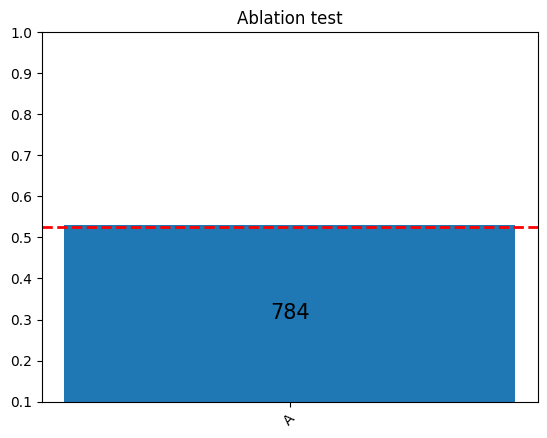

{'train': 0.51876, 'test': 0.5334, 'valid': 0.5262}

In [7]:
from modules.model_trainer import remember, sleep
for epoch in range(10):
    print(f'epoch {epoch}')
    remember(model, datasets['train'], 0.25)

inspect_model(model, datasets, summary_writer, epoch_index=0, level=2, show_fig=True)

In [53]:
from modules.utils import copied_model_with_parameters

In [54]:
model_1 = copied_model_with_parameters(model)

/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


remember, runtime: 0:00:07.110343


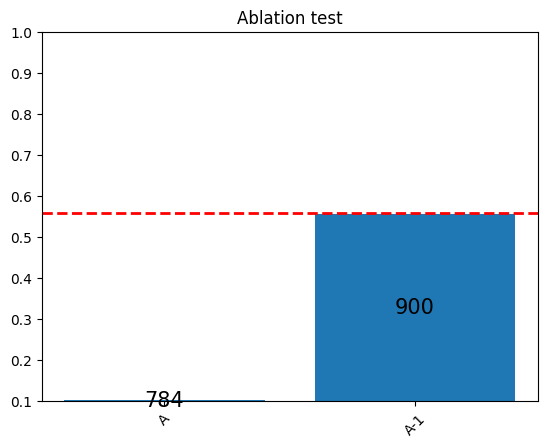

{'train': 0.55928, 'test': 0.5621, 'valid': 0.5569}

In [55]:
# PNMF
model_1.sleep()
remember(model_1, datasets['train'], STDP_freq=0)
inspect_model(model_1, datasets, summary_writer, epoch_index=0, level=2, show_fig=True)

In [18]:
label = tf.eye(10)
label

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [98]:
model_by_shape = copied_model_with_parameters(model_1)
model_by_shape.cortex.init_state(batch_size=10)
broadcasted_labels = model_by_shape.cortex.subcortexs[0].STDP(label, True, 'add')
i_len, o_len = model_by_shape.cortex.subcortexs[0].shape
shape_ratio = float(o_len)/i_len

print(abs(broadcasted_labels.numpy()).mean())
print(abs(model_by_shape.cortex.kernel.numpy()).mean())
print(abs(model_by_shape.cortex.kernel.numpy()>0).mean())
print(abs(model_by_shape.cortex.subcortexs[0].kernel.numpy()).mean())
print(abs(model_by_shape.cortex.subcortexs[0].kernel.numpy()>0).mean())

0.00059718045
0.0012614941
0.3440990132316663
0.0011111113
0.5616666666666666


In [95]:
# model_original = copied_model_with_parameters(model_1)
model_original.cortex.init_state(batch_size=10)
broadcasted_labels = model_original.cortex.subcortexs[0].STDP(label, True, 'add')

print(abs(broadcasted_labels.numpy()).mean())
print(abs(model_original.cortex.kernel.numpy()).mean())
print(abs(model_original.cortex.kernel.numpy()>0).mean())
print(abs(model_original.cortex.subcortexs[0].kernel.numpy()).mean())
print(abs(model_original.cortex.subcortexs[0].kernel.numpy()>0).mean())

0.06172282
0.0010989011
0.4681248598340435
0.1
0.2882222222222222


epoch 0
remember, runtime: 0:00:06.241055


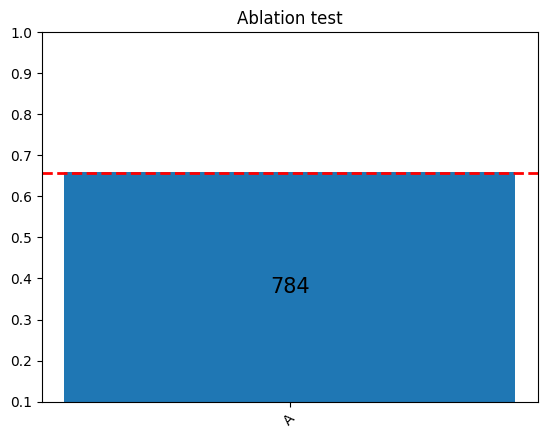

{'train': 0.66042, 'test': 0.6741, 'valid': 0.6573}

In [34]:
for epoch in range(1):
    print(f'epoch {epoch}')
    remember(model_3, datasets['train'], 0.25)

inspect_model(model_3, datasets, summary_writer, epoch_index=0, level=2, show_fig=True)

In [16]:
model_4 = copied_model_with_parameters(model_3)

sleep, runtime: 0:00:00.359815
remember, runtime: 0:00:07.855647


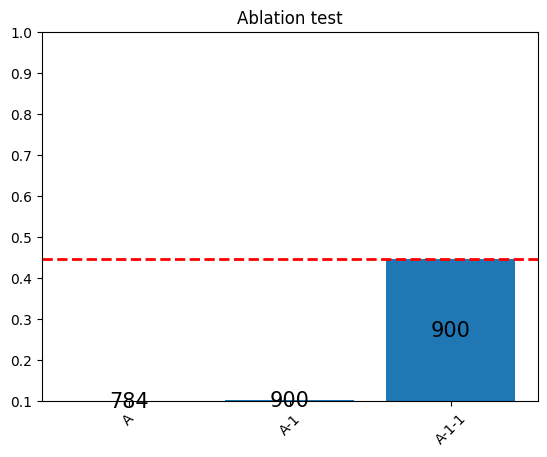

{'train': 0.4519, 'test': 0.4556, 'valid': 0.4462}

In [17]:
sleep(model_4)
remember(model_4, datasets['train'], STDP_freq=0)
inspect_model(model_4, datasets, summary_writer, epoch_index=0, level=2, show_fig=True)

epoch 0
remember, runtime: 0:00:12.718522
epoch 1
remember, runtime: 0:00:12.612945
epoch 2
remember, runtime: 0:00:12.663061
epoch 3
remember, runtime: 0:00:11.975455
epoch 4
remember, runtime: 0:00:12.420689
epoch 5
remember, runtime: 0:00:12.535497
epoch 6
remember, runtime: 0:00:12.383368
epoch 7
remember, runtime: 0:00:12.591380
epoch 8
remember, runtime: 0:00:12.583234
epoch 9
remember, runtime: 0:00:11.724892
epoch 10
remember, runtime: 0:00:12.459371
epoch 11
remember, runtime: 0:00:12.964130
epoch 12
remember, runtime: 0:00:12.417674
epoch 13
remember, runtime: 0:00:12.664915
epoch 14
remember, runtime: 0:00:12.551885
epoch 15
remember, runtime: 0:00:12.294706
epoch 16
remember, runtime: 0:00:12.225217
epoch 17
remember, runtime: 0:00:12.535541
epoch 18
remember, runtime: 0:00:12.567619
epoch 19
remember, runtime: 0:00:12.698314
epoch 20
remember, runtime: 0:00:12.717050
epoch 21
remember, runtime: 0:00:13.148188
epoch 22
remember, runtime: 0:00:13.829956
epoch 23
remember, ru

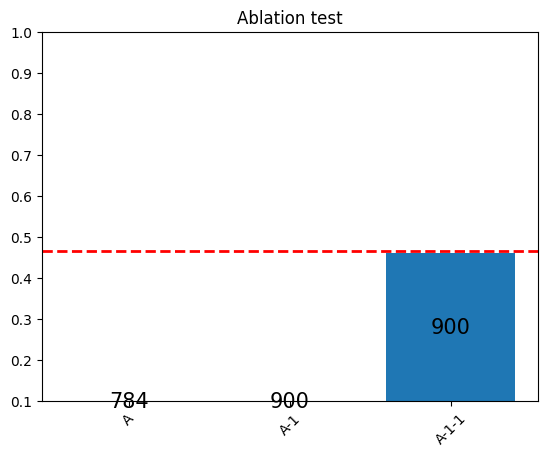

{'train': 0.47128, 'test': 0.4644, 'valid': 0.4652}

In [18]:
for epoch in range(50):
    print(f'epoch {epoch}')
    remember(model_4, datasets['train'], 0.25)

inspect_model(model_4, datasets, summary_writer, epoch_index=0, level=2, show_fig=True)

In [25]:
model_4.cortex.subcortexs[0].subcortexs[0]

In [26]:
model_4.cortex.init_state(100)

In [27]:
model_4